In [1]:
import glob
import numpy as np
import os
import pandas as pd
import scipy.io as sio
import seaborn as sns
import matplotlib.pyplot as plt
from feast import *

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV

In [2]:
sns.set_style("whitegrid")
cwd = os.path.dirname(os.getcwd())
data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data')

In [3]:
subject_files = glob.glob(os.path.join(data_dir, 'dFNC_August_2017', 'rest_dfnc_sub_*_sess_001_results.mat'))

In [4]:
dfnc_std = []
for subject in sorted(subject_files):
    matrix = sio.loadmat(subject)
    dfnc_std.append(np.reshape(np.var(matrix['FNCdyn'], axis=0), (1, -1)))
    
dfnc_std = np.concatenate(dfnc_std, axis=0)

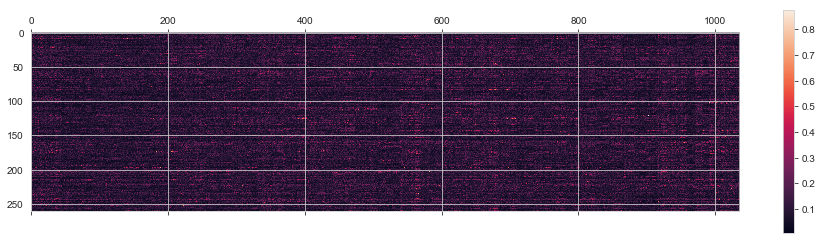

In [5]:
plt.matshow(dfnc_std)
plt.colorbar()
plt.show()

In [6]:
demographics = pd.read_excel(os.path.join(data_dir, '20160420_vcalhoun_rest_demography_cag_info_new.xls'))

In [7]:
X = dfnc_std
y = demographics.cap_d_group_id2.values

In [8]:
np.unique(dfnc_std)

array([0.00511851, 0.00575433, 0.00579716, ..., 0.85079862, 0.86488575,
       0.87411618])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y)

In [10]:
def feast_and_fitting(Xtrain, Xtest, ytrain, ytest):
    
    lr = LogisticRegression(solver='lbfgs', max_iter=1e6)
    svc = LinearSVC(max_iter=1e6)
    rbf = SVC(gamma='scale')
    rf = RandomForestClassifier()
    knn  = KNeighborsClassifier()

    algos = [BetaGamma, DISR, CIFE, CMIM, CondMI, Condred]
    num_features_list = range(10, 101, 10)
    classifiers = [lr, svc, rbf, rf, knn]

    acc_matrix = np.zeros((len(algos), len(num_features_list), len(classifiers)))
    f1_matrix = np.zeros(acc_matrix.shape)
    auc_matrix = np.zeros(f1_matrix.shape)

    for i, algo in enumerate(algos):
        for j, num_features in enumerate(num_features_list):
            select_feature_index = algo(Xtrain, ytrain, num_features)

            X_train_select = Xtrain[:, np.array(select_feature_index).astype(int)]
            y_train_select = ytrain

            X_test_select = Xtest[:, np.array(select_feature_index).astype(int)]
            y_test_select = ytest

            for k, classifier in enumerate(classifiers):
                classifier.fit(X_train_select, y_train_select)

                y_pred = classifier.predict(X_test_select)
                false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_select, y_pred, pos_label=0)

                acc_matrix[i, j, k] = accuracy_score(y_test_select, y_pred)
                f1_matrix[i, j, k] = f1_score(y_test_select, y_pred, pos_label=0)
                auc_matrix[i, j, k] = auc(false_positive_rate, true_positive_rate)

    print_plots(acc_matrix, f1_matrix, auc_matrix)
    
    return (acc_matrix, f1_matrix, auc_matrix)

In [11]:
def print_plots(acc_matrix, f1_matrix, auc_matrix):
    classifier_labels = ['lr', 'svc', 'rbf', 'rf', 'knn']
    algo_labels = ['BetaGamma', 'DISR', 'CIFE', 'CMIM', 'CondMI', 'Condred']
    for i in range(acc_matrix.shape[0]):
        plt.figure(i)
        for j in range(acc_matrix.shape[2]):
            plt.plot(acc_matrix[i, :, j], label=str(classifier_labels[j]), linestyle=':')
            plt.title('Accuracy - ' + algo_labels[i])
            plt.legend()

        plt.show()

    for i in range(acc_matrix.shape[0]):
        plt.figure(i)
        for j in range(acc_matrix.shape[2]):
            plt.plot(f1_matrix[i, :, j], label=str(classifier_labels[j]), linestyle=':')
            plt.title('F1 - ' + algo_labels[i])
            plt.legend()

        plt.show()

    for i in range(acc_matrix.shape[0]):
        plt.figure(i)
        for j in range(acc_matrix.shape[2]):
            plt.plot(auc_matrix[i, :, j], label=str(classifier_labels[j]), linestyle=':')
            plt.title('AUC - ' + algo_labels[i])
            plt.legend()

        plt.show()

/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/python2/lib/python2.7/site-packages/

/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/python2/lib/python2.7/site-packages/skle

/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/python2/lib/python2.7/site-packages/skle

/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/python2/lib/python2.7/site-packages/skle

/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/python2/lib/python2.7/site-packages/skle

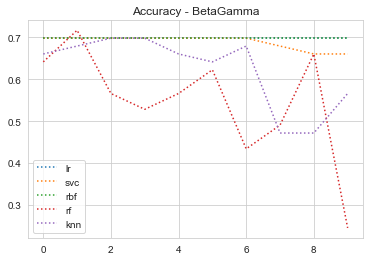

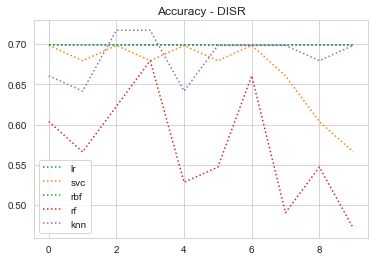

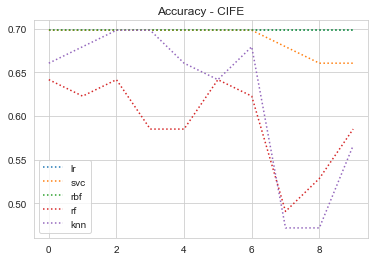

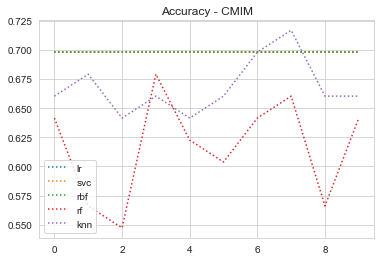

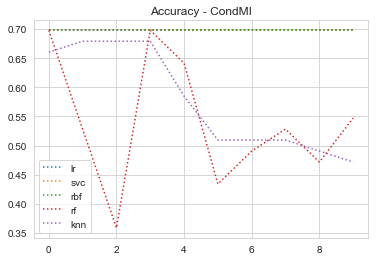

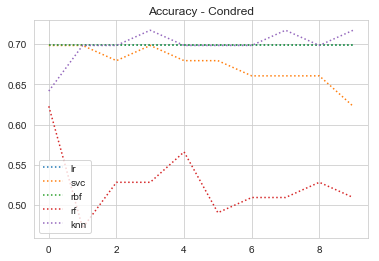

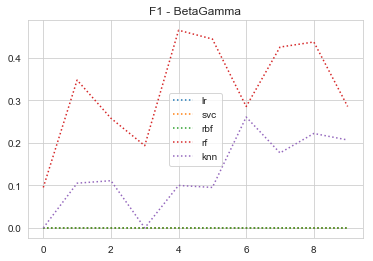

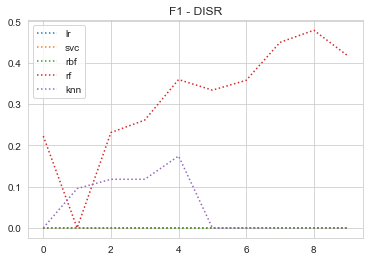

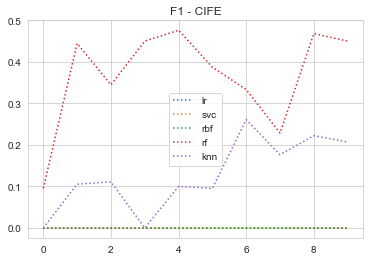

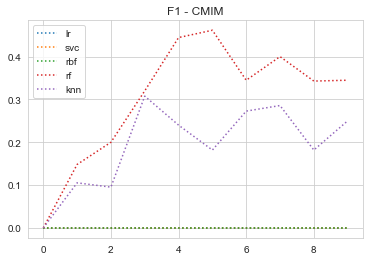

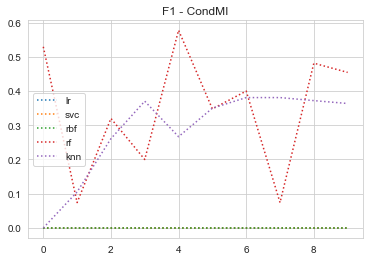

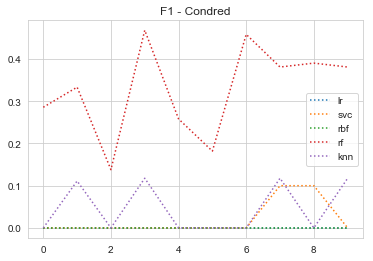

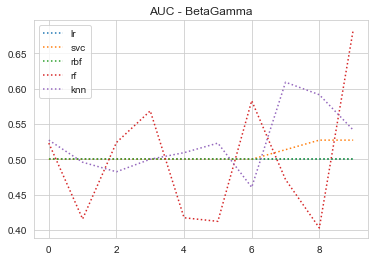

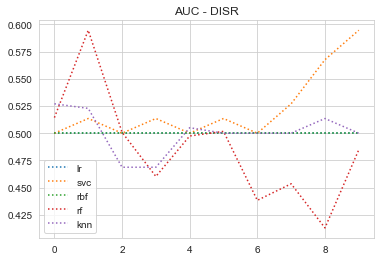

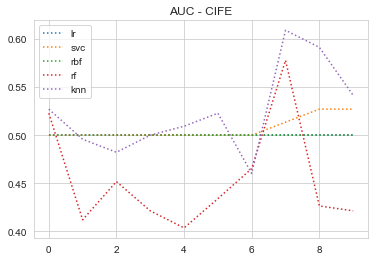

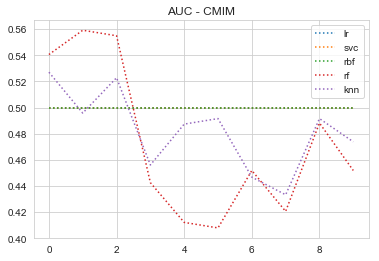

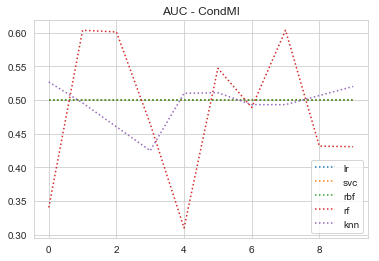

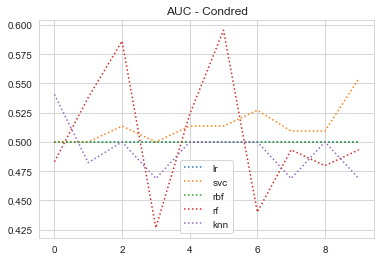

(array([[[0.69811321, 0.69811321, 0.69811321, 0.64150943, 0.66037736],
         [0.69811321, 0.69811321, 0.69811321, 0.71698113, 0.67924528],
         [0.69811321, 0.69811321, 0.69811321, 0.56603774, 0.69811321],
         [0.69811321, 0.69811321, 0.69811321, 0.52830189, 0.69811321],
         [0.69811321, 0.69811321, 0.69811321, 0.56603774, 0.66037736],
         [0.69811321, 0.69811321, 0.69811321, 0.62264151, 0.64150943],
         [0.69811321, 0.69811321, 0.69811321, 0.43396226, 0.67924528],
         [0.69811321, 0.67924528, 0.69811321, 0.49056604, 0.47169811],
         [0.69811321, 0.66037736, 0.69811321, 0.66037736, 0.47169811],
         [0.69811321, 0.66037736, 0.69811321, 0.24528302, 0.56603774]],
 
        [[0.69811321, 0.69811321, 0.69811321, 0.60377358, 0.66037736],
         [0.69811321, 0.67924528, 0.69811321, 0.56603774, 0.64150943],
         [0.69811321, 0.69811321, 0.69811321, 0.62264151, 0.71698113],
         [0.69811321, 0.67924528, 0.69811321, 0.67924528, 0.71698113],
   

In [12]:
feast_and_fitting(X_train * 2, X_test, y_train, y_test)

In [13]:
dfnc_mean = []
for subject in sorted(subject_files):
    matrix = sio.loadmat(subject)
    dfnc_mean.append(np.reshape(np.mean(matrix['FNCdyn'], axis=0), (1, -1)))
    
dfnc_mean = np.concatenate(dfnc_mean, axis=0)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(dfnc_mean, y,
                                                    test_size=0.2,
                                                    stratify=y)

/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/python2/lib/python2.7/site-packages/skle

/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/python2/lib/python2.7/site-packages/skle

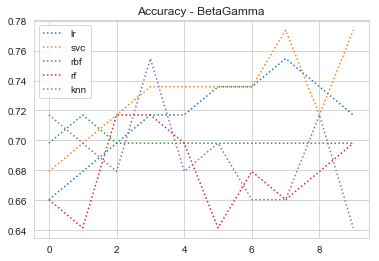

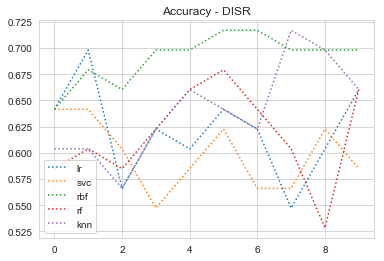

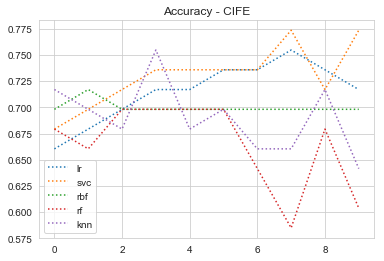

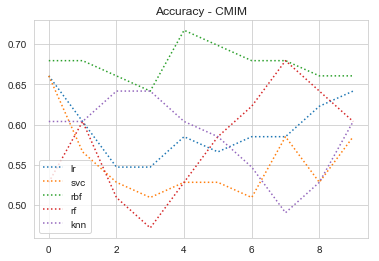

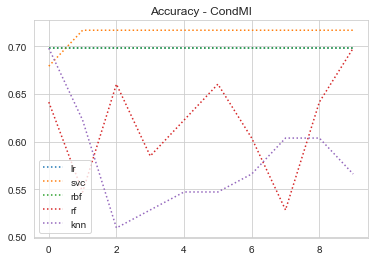

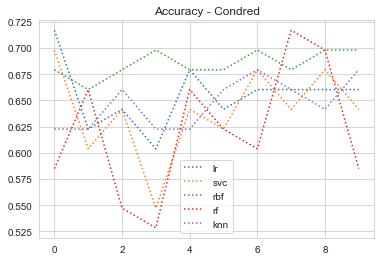

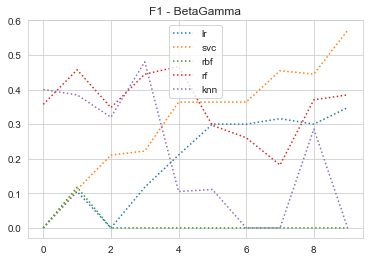

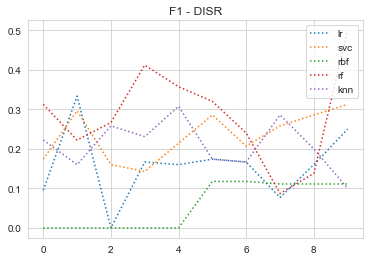

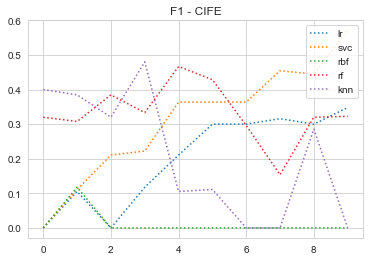

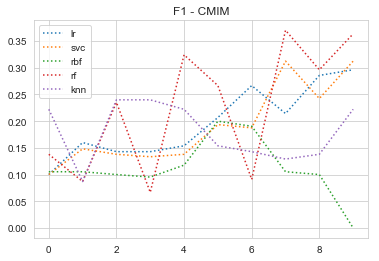

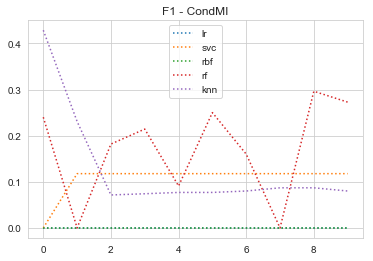

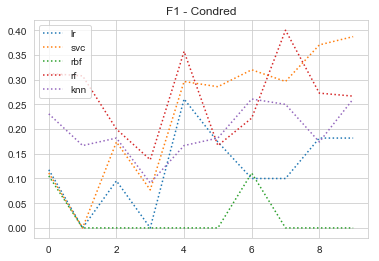

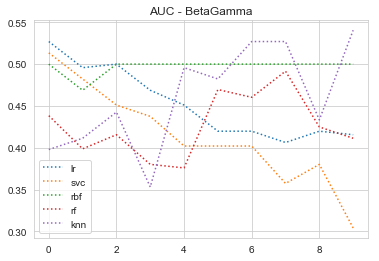

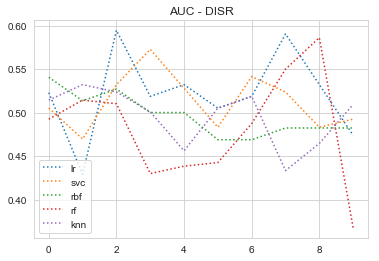

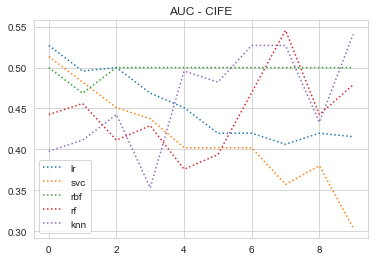

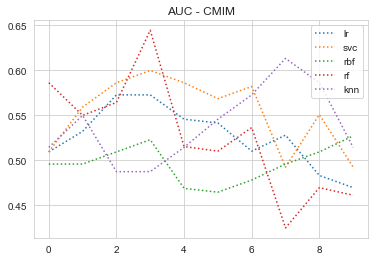

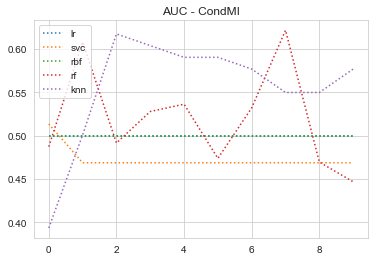

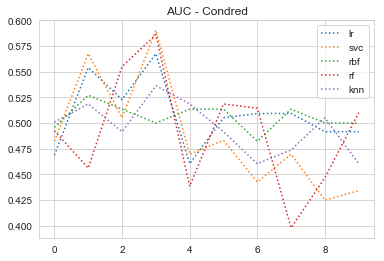

(array([[[0.66037736, 0.67924528, 0.69811321, 0.66037736, 0.71698113],
         [0.67924528, 0.69811321, 0.71698113, 0.64150943, 0.69811321],
         [0.69811321, 0.71698113, 0.69811321, 0.71698113, 0.67924528],
         [0.71698113, 0.73584906, 0.69811321, 0.71698113, 0.75471698],
         [0.71698113, 0.73584906, 0.69811321, 0.69811321, 0.67924528],
         [0.73584906, 0.73584906, 0.69811321, 0.64150943, 0.69811321],
         [0.73584906, 0.73584906, 0.69811321, 0.67924528, 0.66037736],
         [0.75471698, 0.77358491, 0.69811321, 0.66037736, 0.66037736],
         [0.73584906, 0.71698113, 0.69811321, 0.67924528, 0.71698113],
         [0.71698113, 0.77358491, 0.69811321, 0.69811321, 0.64150943]],
 
        [[0.64150943, 0.64150943, 0.64150943, 0.58490566, 0.60377358],
         [0.69811321, 0.64150943, 0.67924528, 0.60377358, 0.60377358],
         [0.56603774, 0.60377358, 0.66037736, 0.58490566, 0.56603774],
         [0.62264151, 0.54716981, 0.69811321, 0.62264151, 0.62264151],
   

In [15]:
feast_and_fitting(X_train, X_test, y_train, y_test)